# Customer Segmentation using Clustering

This notebook explores different clustering algorithms to segment wholesale customers based on their annual spending across product categories. The goal is to identify distinct customer groups that could inform marketing strategies.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

# for reproducibility
np.random.seed(42)

## Loading the Data

Using the Wholesale Customers dataset from UCI Machine Learning Repository. It contains annual spending (in monetary units) on different product categories for clients of a wholesale distributor.

In [4]:
# load directly from UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"

try:
    df = pd.read_csv(url)
    print("Loaded from UCI")
except:
    print("URL failed, using local backup")
    
df.head()

Loaded from UCI


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Shape: (440, 8)

Columns: ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


### Feature Description

- **Channel**: Customer channel (1 = Hotel/Restaurant/Cafe, 2 = Retail)
- **Region**: Customer region (1 = Lisbon, 2 = Oporto, 3 = Other)
- **Fresh**: Annual spending on fresh products
- **Milk**: Annual spending on milk products
- **Grocery**: Annual spending on grocery products
- **Frozen**: Annual spending on frozen products
- **Detergents_Paper**: Annual spending on detergents and paper products
- **Delicassen**: Annual spending on delicatessen products

All spending values are in some monetary unit (not specified in the original dataset).

In [7]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [8]:
# check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


## Exploratory Data Analysis

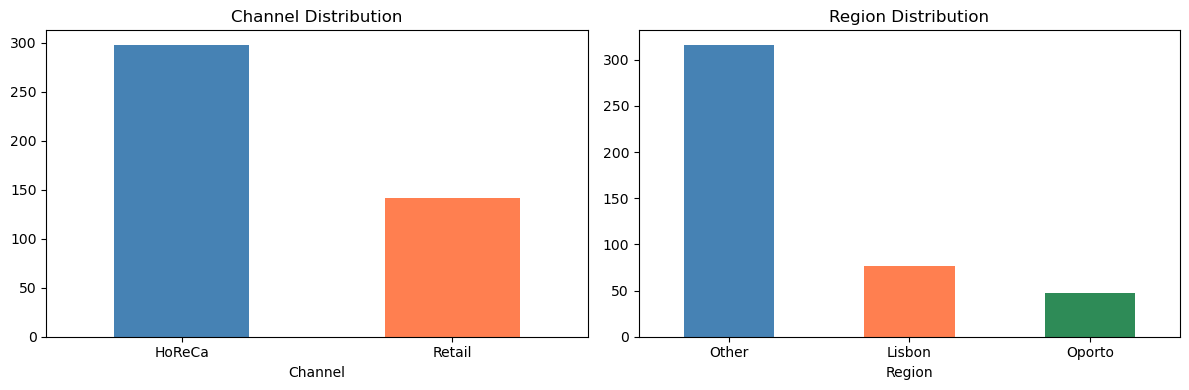

In [9]:
# check the categorical variables
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df['Channel'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Channel Distribution')
axes[0].set_xticklabels(['HoReCa', 'Retail'], rotation=0)

df['Region'].value_counts().plot(kind='bar', ax=axes[1], color=['steelblue', 'coral', 'seagreen'])
axes[1].set_title('Region Distribution')
axes[1].set_xticklabels(['Other', 'Lisbon', 'Oporto'], rotation=0)

plt.tight_layout()
plt.show()

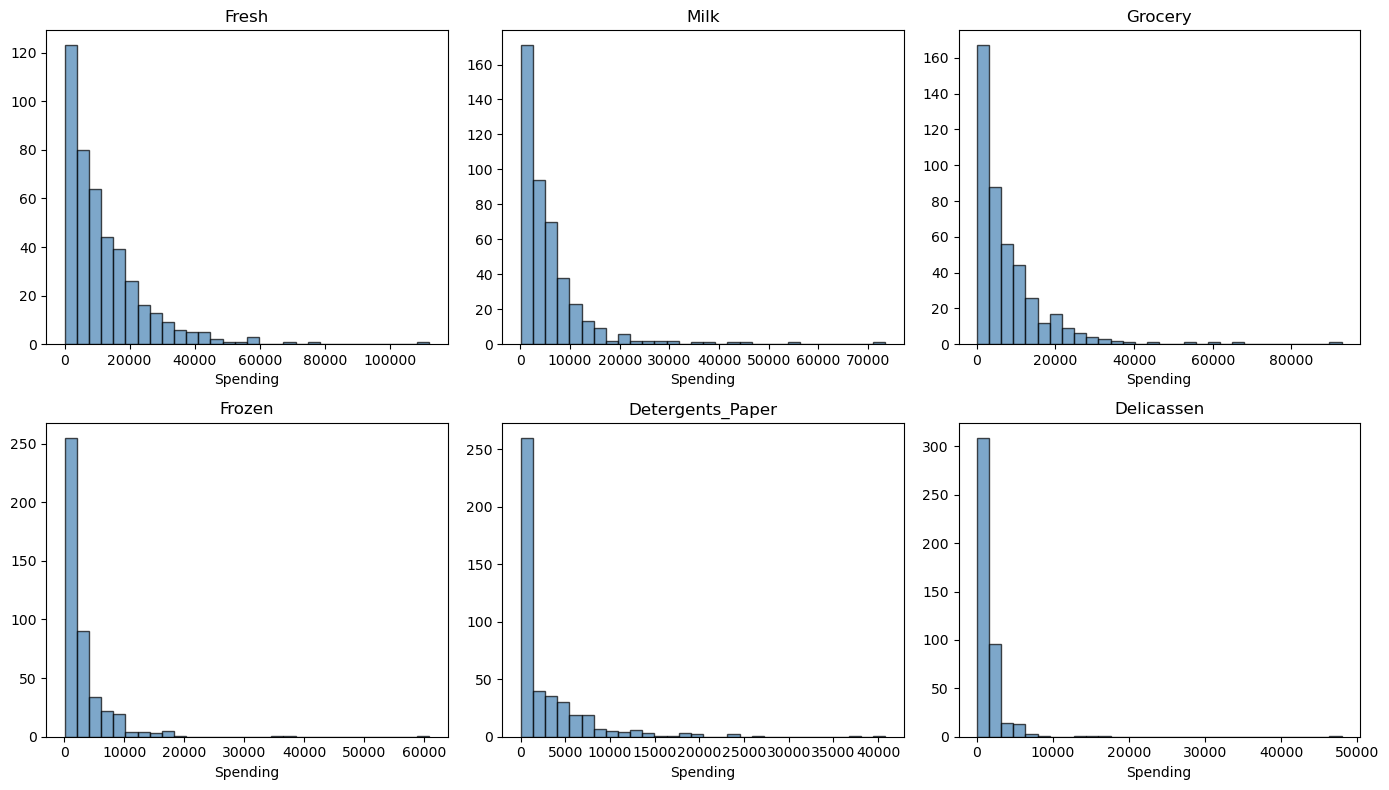

In [10]:
# distribution of spending categories
spending_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(spending_cols):
    axes[i].hist(df[col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('Spending')
    
plt.tight_layout()
plt.show()

# clearly right-skewed distributions - might need log transform

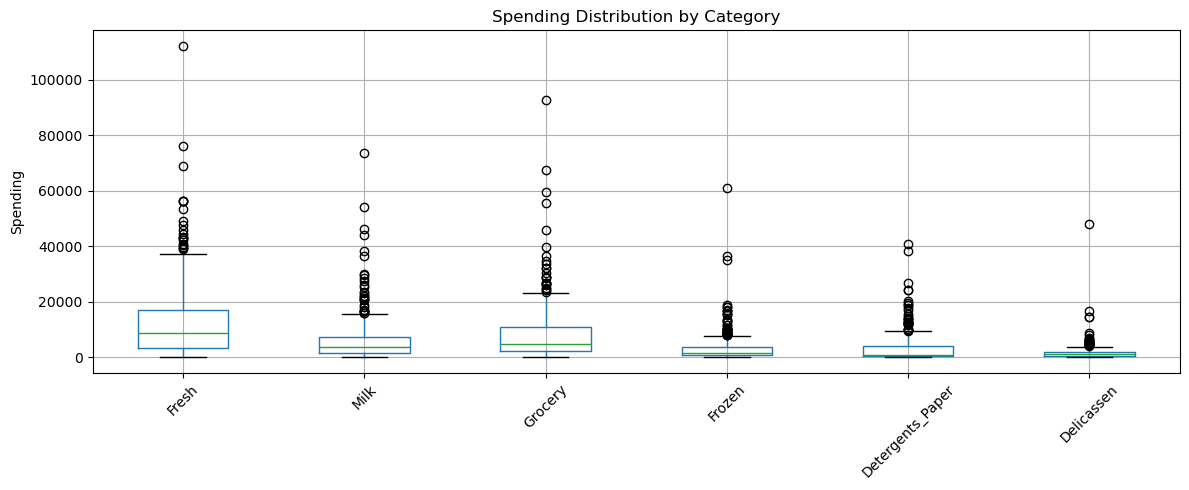

In [11]:
# boxplots to see outliers better
fig, ax = plt.subplots(figsize=(12, 5))
df[spending_cols].boxplot(ax=ax)
ax.set_title('Spending Distribution by Category')
ax.set_ylabel('Spending')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# lots of outliers, especially in Fresh and Grocery

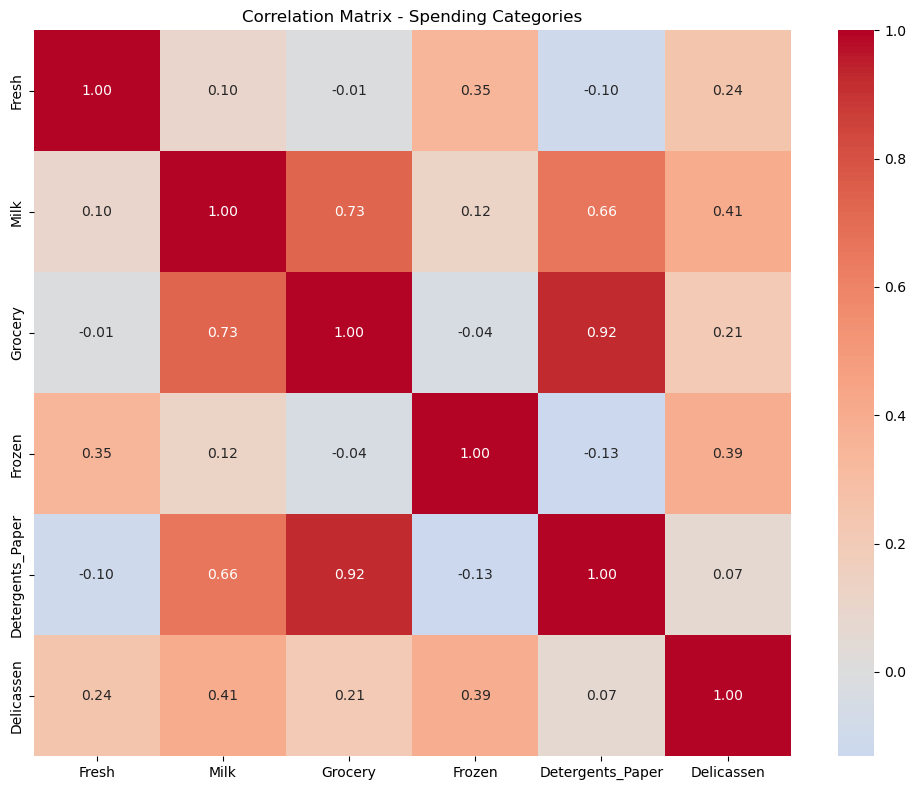

In [12]:
# correlation matrix
plt.figure(figsize=(10, 8))
corr = df[spending_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix - Spending Categories')
plt.tight_layout()
plt.show()

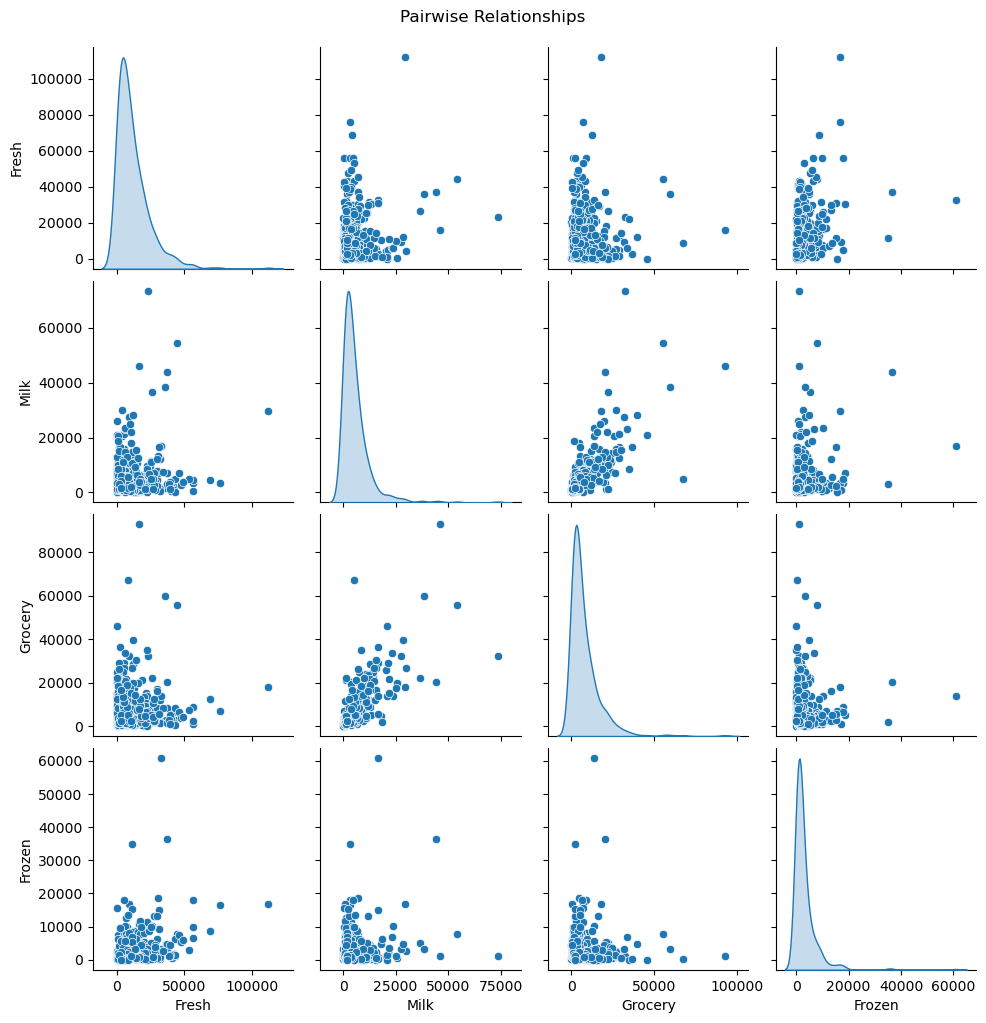

In [13]:
# pairplot for the main spending categories
# using only a few to keep it readable
sns.pairplot(df[['Fresh', 'Milk', 'Grocery', 'Frozen']], diag_kind='kde')
plt.suptitle('Pairwise Relationships', y=1.02)
plt.show()

## Data Preprocessing

For clustering, I'll focus on the spending columns only. Channel and Region could be used for validation later but shouldn't drive the clustering.

In [14]:
# select only spending features for clustering
X = df[spending_cols].copy()
print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (440, 6)


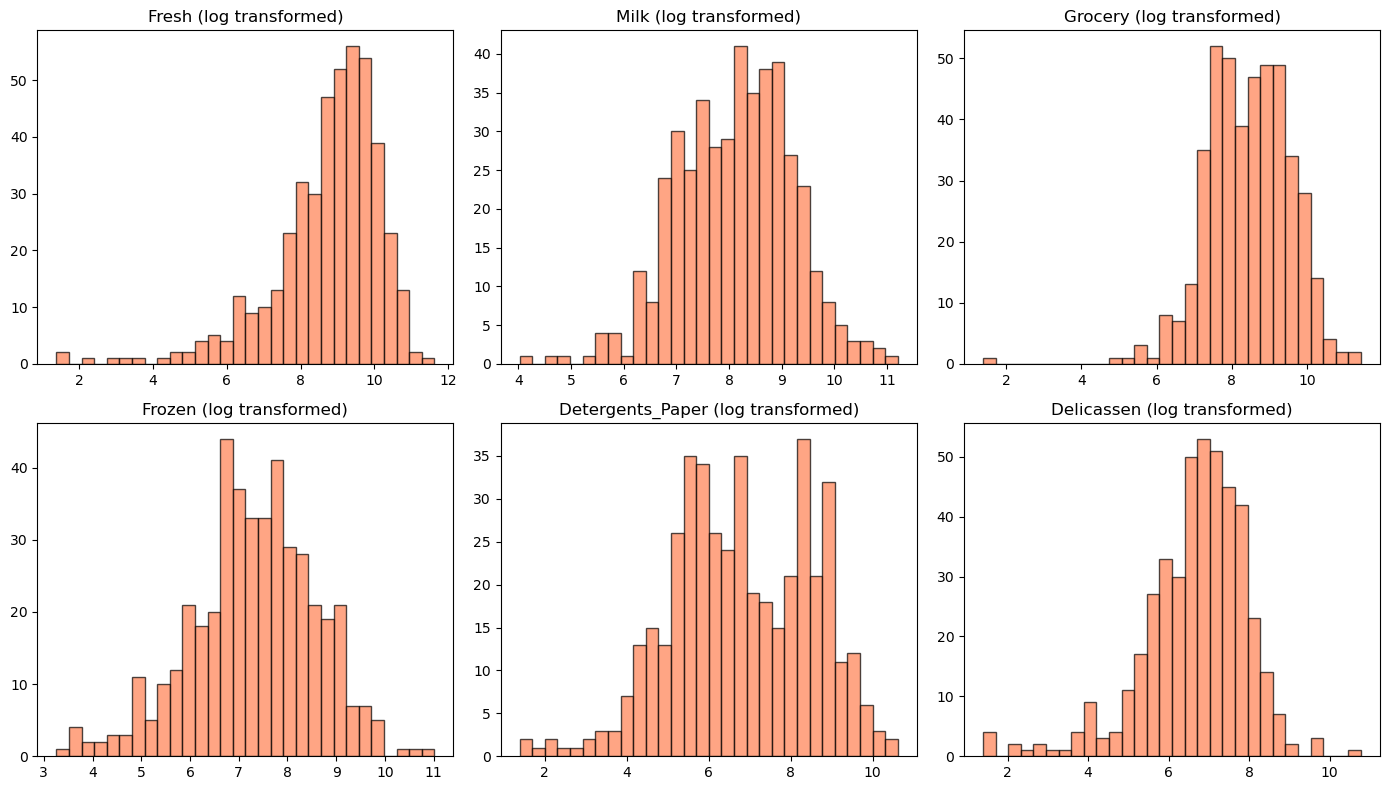

In [15]:
# the distributions are heavily skewed, lets try log transform
X_log = np.log1p(X)  # log(1+x) to handle zeros

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(spending_cols):
    axes[i].hist(X_log[col], bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col} (log transformed)')
    
plt.tight_layout()
plt.show()

# much better distributions now

In [16]:
from sklearn.preprocessing import StandardScaler

# scale the log-transformed data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# convert back to dataframe for convenience
X_scaled_df = pd.DataFrame(X_scaled, columns=spending_cols)

print("Scaled data statistics:")
print(X_scaled_df.describe().round(2))

Scaled data statistics:
        Fresh    Milk  Grocery  Frozen  Detergents_Paper  Delicassen
count  440.00  440.00   440.00  440.00            440.00      440.00
mean     0.00   -0.00    -0.00    0.00             -0.00       -0.00
std      1.00    1.00     1.00    1.00              1.00        1.00
min     -5.00   -3.79    -6.36   -3.16             -3.17       -4.09
25%     -0.47   -0.73    -0.69   -0.54             -0.73       -0.51
50%      0.21    0.07     0.02    0.02             -0.05        0.16
75%      0.68    0.70     0.75    0.68              0.87        0.65
max      1.97    2.86     2.70    2.90              2.24        3.18


## Finding the Optimal Number of Clusters

Will use multiple methods to determine the best K.

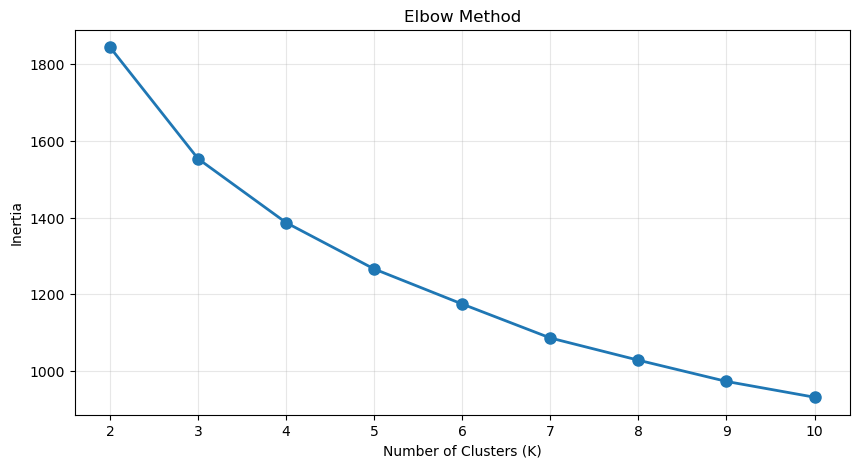

In [19]:
from sklearn.cluster import KMeans

# elbow method
inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True, alpha=0.3)
plt.show()


K=2: silhouette = 0.2903
K=3: silhouette = 0.2594
K=4: silhouette = 0.1885
K=5: silhouette = 0.1916
K=6: silhouette = 0.2009
K=7: silhouette = 0.1958
K=8: silhouette = 0.1852
K=9: silhouette = 0.1965
K=10: silhouette = 0.1905


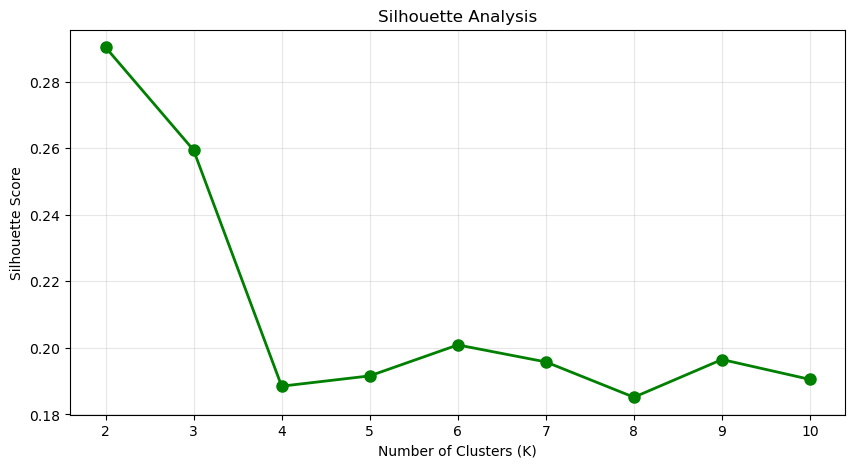


Best K by silhouette: 2


In [20]:
from sklearn.metrics import silhouette_score

# silhouette analysis
sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"K={k}: silhouette = {score:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(K_range, sil_scores, 'o-', linewidth=2, markersize=8, color='green')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True, alpha=0.3)
plt.show()

best_k_sil = K_range[np.argmax(sil_scores)]
print(f"\nBest K by silhouette: {best_k_sil}")

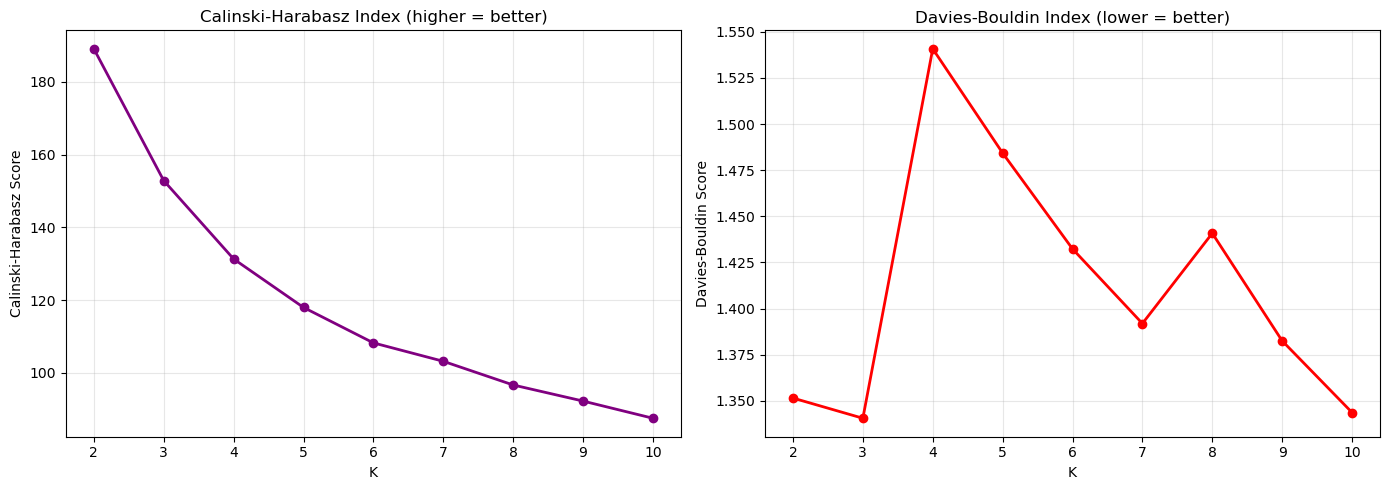

In [21]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# additional metrics
ch_scores = []
db_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, ch_scores, 'o-', linewidth=2, color='purple')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Calinski-Harabasz Score')
axes[0].set_title('Calinski-Harabasz Index (higher = better)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, db_scores, 'o-', linewidth=2, color='red')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Davies-Bouldin Score')
axes[1].set_title('Davies-Bouldin Index (lower = better)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

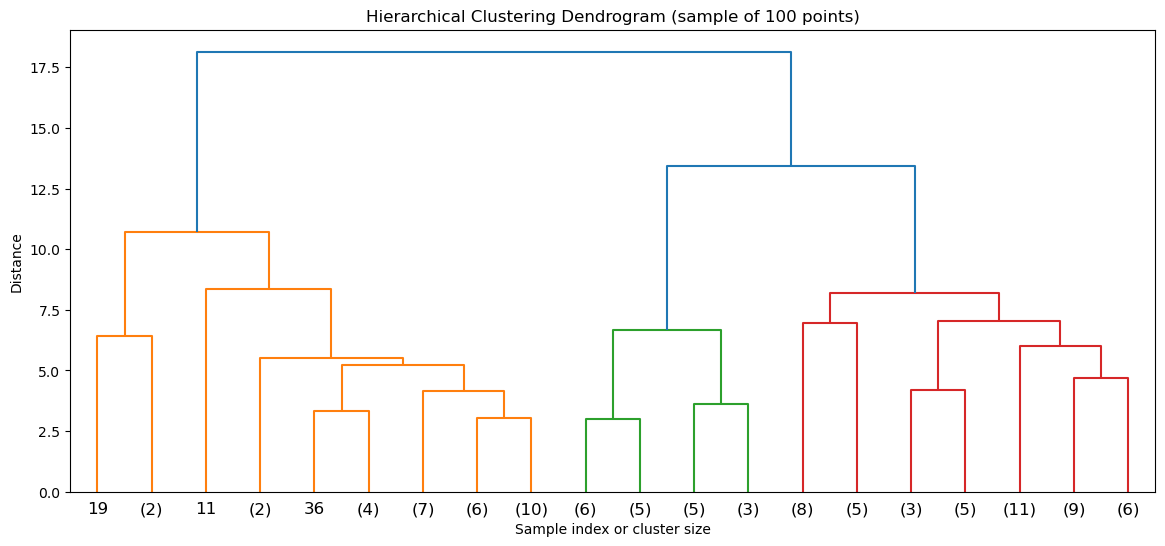

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage

# hierarchical clustering dendrogram
# using a sample because full dataset makes the dendrogram hard to read
sample_idx = np.random.choice(len(X_scaled), size=100, replace=False)
X_sample = X_scaled[sample_idx]

linkage_matrix = linkage(X_sample, method='ward')

plt.figure(figsize=(14, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20)
plt.title('Hierarchical Clustering Dendrogram (sample of 100 points)')
plt.xlabel('Sample index or cluster size')
plt.ylabel('Distance')
plt.show()

Based on the analysis above, K=2 or K=3 seem reasonable. The silhouette score suggests K=2 is best statistically, but K=3 might give more actionable business segments. I'll proceed with both and compare.

---

## Clustering Algorithms

Going to try several different approaches and compare results.

### 1. K-Means

In [23]:
from sklearn.cluster import KMeans

# trying with K=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

print("K-Means (K=3) Results:")
print(f"Inertia: {kmeans.inertia_:.2f}")
print(f"Silhouette: {silhouette_score(X_scaled, kmeans_labels):.4f}")
print(f"\nCluster sizes:")
print(pd.Series(kmeans_labels).value_counts().sort_index())

K-Means (K=3) Results:
Inertia: 1553.42
Silhouette: 0.2594

Cluster sizes:
0     80
1    147
2    213
Name: count, dtype: int64


### 2. Agglomerative Clustering

In [24]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_labels = agg.fit_predict(X_scaled)

print("Agglomerative Clustering (K=3) Results:")
print(f"Silhouette: {silhouette_score(X_scaled, agg_labels):.4f}")
print(f"\nCluster sizes:")
print(pd.Series(agg_labels).value_counts().sort_index())

Agglomerative Clustering (K=3) Results:
Silhouette: 0.2547

Cluster sizes:
0    262
1     53
2    125
Name: count, dtype: int64


### 3. DBSCAN

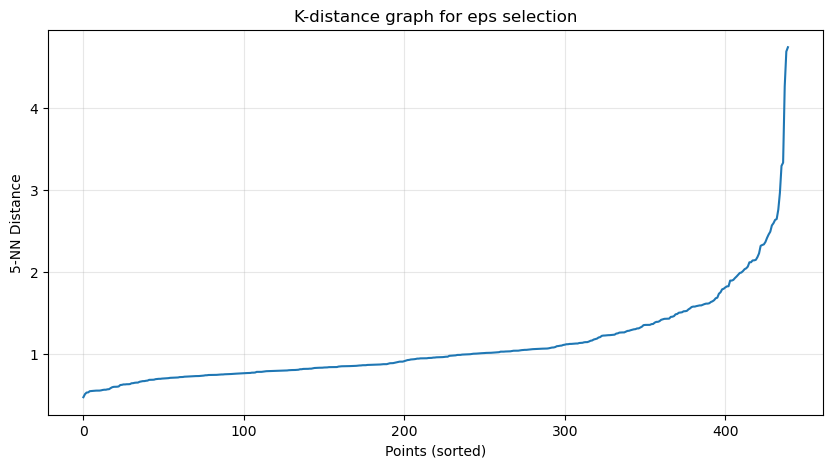

In [25]:
from sklearn.neighbors import NearestNeighbors

# finding good eps value
k = 5
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
distances = np.sort(distances[:, k-1])

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.xlabel('Points (sorted)')
plt.ylabel(f'{k}-NN Distance')
plt.title('K-distance graph for eps selection')
plt.grid(True, alpha=0.3)
plt.show()

# looks like eps around 1.5-2.0 might work

In [29]:
from sklearn.cluster import DBSCAN

# trying a few eps values
for eps in [0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10, 20]:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    print(f"eps={eps}: {n_clusters} clusters, {n_noise} noise points")

# going with eps=1.5
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

print(f"\nDBSCAN cluster distribution:")
print(pd.Series(dbscan_labels).value_counts().sort_index())

eps=0.01: 0 clusters, 440 noise points
eps=0.1: 0 clusters, 440 noise points
eps=0.5: 1 clusters, 435 noise points
eps=1.0: 1 clusters, 124 noise points
eps=1.5: 1 clusters, 41 noise points
eps=2.0: 1 clusters, 12 noise points
eps=5.0: 1 clusters, 0 noise points
eps=10: 1 clusters, 0 noise points
eps=20: 1 clusters, 0 noise points

DBSCAN cluster distribution:
-1     41
 0    399
Name: count, dtype: int64


### 4. Gaussian Mixture Model

In [30]:
from sklearn.mixture import GaussianMixture

# GMM with 3 components
gmm = GaussianMixture(n_components=3, random_state=42, covariance_type='full')
gmm_labels = gmm.fit_predict(X_scaled)

print("GMM (n=3) Results:")
print(f"BIC: {gmm.bic(X_scaled):.2f}")
print(f"AIC: {gmm.aic(X_scaled):.2f}")
print(f"Silhouette: {silhouette_score(X_scaled, gmm_labels):.4f}")
print(f"\nCluster sizes:")
print(pd.Series(gmm_labels).value_counts().sort_index())

GMM (n=3) Results:
BIC: 6442.48
AIC: 6103.28
Silhouette: 0.1057

Cluster sizes:
0     68
1    199
2    173
Name: count, dtype: int64


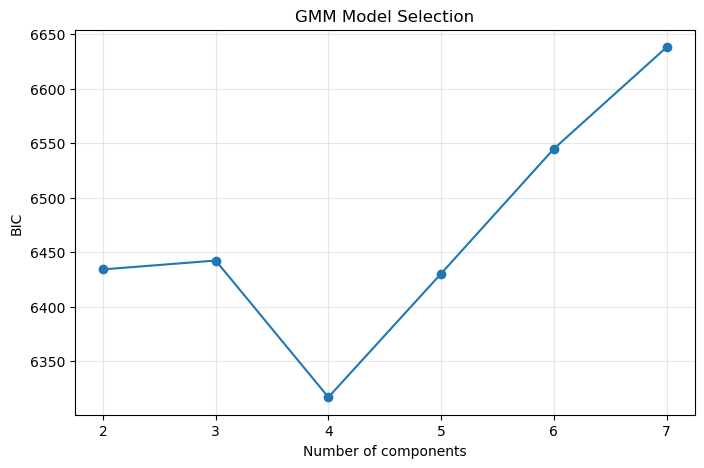

Optimal n_components by BIC: 4


In [31]:
# check optimal number of components using BIC
bics = []
for n in range(2, 8):
    gm = GaussianMixture(n_components=n, random_state=42)
    gm.fit(X_scaled)
    bics.append(gm.bic(X_scaled))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 8), bics, 'o-')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('GMM Model Selection')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Optimal n_components by BIC: {range(2, 8)[np.argmin(bics)]}")

### 5. Mean Shift

In [32]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X_scaled, quantile=0.3)
print(f"Estimated bandwidth: {bandwidth:.3f}")

ms = MeanShift(bandwidth=bandwidth)
ms_labels = ms.fit_predict(X_scaled)

print(f"\nMean Shift found {len(np.unique(ms_labels))} clusters")
print(f"Silhouette: {silhouette_score(X_scaled, ms_labels):.4f}")
print(f"\nCluster sizes:")
print(pd.Series(ms_labels).value_counts().sort_index())

Estimated bandwidth: 2.503

Mean Shift found 5 clusters
Silhouette: 0.3528

Cluster sizes:
0    423
1      7
2      3
3      4
4      3
Name: count, dtype: int64


### 6. Fuzzy C-Means

Unlike K-Means which does hard assignment, FCM gives each point a membership degree to each cluster. This can be useful when boundaries between customer segments are not clear-cut.

In [33]:
import skfuzzy as fuzz

# FCM requires data in shape (n_features, n_samples)
X_fcm = X_scaled.T

# run fuzzy c-means with 3 clusters
# m is the fuzziness parameter (m=2 is common)
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_fcm, c=3, m=2, error=0.005, maxiter=1000, init=None, seed=42
)

# u contains membership values - shape is (n_clusters, n_samples)
# hard labels from max membership
fcm_labels = np.argmax(u, axis=0)

print("Fuzzy C-Means (c=3) Results:")
print(f"Fuzzy Partition Coefficient (FPC): {fpc:.4f}")
print(f"  (FPC close to 1 means good clustering, close to 1/c means overlapping)")
print(f"Silhouette (hard labels): {silhouette_score(X_scaled, fcm_labels):.4f}")
print(f"\nCluster sizes:")
print(pd.Series(fcm_labels).value_counts().sort_index())

Fuzzy C-Means (c=3) Results:
Fuzzy Partition Coefficient (FPC): 0.4432
  (FPC close to 1 means good clustering, close to 1/c means overlapping)
Silhouette (hard labels): 0.1478

Cluster sizes:
0    163
1    159
2    118
Name: count, dtype: int64


In [34]:
# lets look at some membership values
membership_df = pd.DataFrame(u.T, columns=['Cluster_0', 'Cluster_1', 'Cluster_2'])
membership_df['Hard_Label'] = fcm_labels

print("Sample membership values (first 10 samples):")
print(membership_df.head(10).round(3))

# find samples with high uncertainty (no clear cluster)
max_membership = membership_df[['Cluster_0', 'Cluster_1', 'Cluster_2']].max(axis=1)
uncertain = membership_df[max_membership < 0.6]
print(f"\nSamples with max membership < 0.6 (uncertain): {len(uncertain)}")

Sample membership values (first 10 samples):
   Cluster_0  Cluster_1  Cluster_2  Hard_Label
0      0.144      0.577      0.279           1
1      0.050      0.820      0.130           1
2      0.154      0.550      0.295           1
3      0.456      0.130      0.414           0
4      0.217      0.380      0.403           2
5      0.121      0.533      0.347           1
6      0.180      0.411      0.409           1
7      0.093      0.660      0.248           1
8      0.167      0.390      0.443           2
9      0.047      0.855      0.098           1

Samples with max membership < 0.6 (uncertain): 294


c=2: FPC=0.6456
c=3: FPC=0.4432
c=4: FPC=0.3633
c=5: FPC=0.2997
c=6: FPC=0.2551
c=7: FPC=0.2285


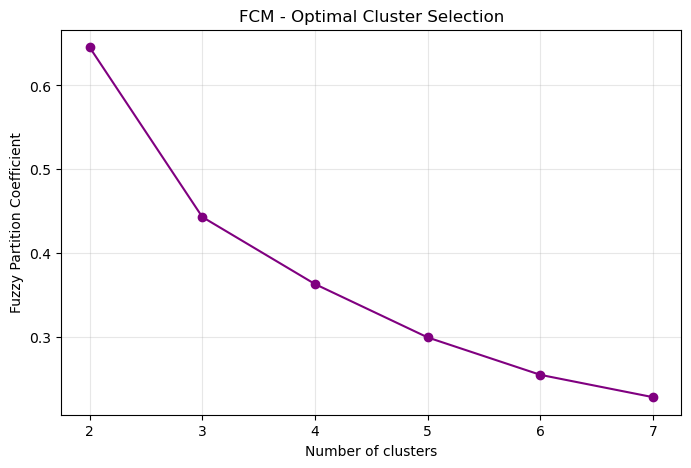

In [35]:
# find optimal number of clusters using FPC
fpcs = []
for c in range(2, 8):
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        X_fcm, c=c, m=2, error=0.005, maxiter=1000, seed=42
    )
    fpcs.append(fpc)
    print(f"c={c}: FPC={fpc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range(2, 8), fpcs, 'o-', color='purple')
plt.xlabel('Number of clusters')
plt.ylabel('Fuzzy Partition Coefficient')
plt.title('FCM - Optimal Cluster Selection')
plt.grid(True, alpha=0.3)
plt.show()

---

## Comparison of Results

In [36]:
# collect all results
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

def get_metrics(X, labels, name):
    # filter noise for DBSCAN
    mask = labels >= 0
    if mask.sum() < len(labels) and len(np.unique(labels[mask])) >= 2:
        X_clean = X[mask]
        labels_clean = labels[mask]
    else:
        X_clean = X
        labels_clean = labels
    
    if len(np.unique(labels_clean)) < 2:
        return None
        
    return {
        'Algorithm': name,
        'n_clusters': len(np.unique(labels_clean)),
        'Silhouette': silhouette_score(X_clean, labels_clean),
        'Calinski-Harabasz': calinski_harabasz_score(X_clean, labels_clean),
        'Davies-Bouldin': davies_bouldin_score(X_clean, labels_clean)
    }

results = []
results.append(get_metrics(X_scaled, kmeans_labels, 'K-Means'))
results.append(get_metrics(X_scaled, agg_labels, 'Agglomerative'))
results.append(get_metrics(X_scaled, dbscan_labels, 'DBSCAN'))
results.append(get_metrics(X_scaled, gmm_labels, 'GMM'))
results.append(get_metrics(X_scaled, ms_labels, 'Mean Shift'))
results.append(get_metrics(X_scaled, fcm_labels, 'Fuzzy C-Means'))

results = [r for r in results if r is not None]
comparison_df = pd.DataFrame(results).set_index('Algorithm')

print("Algorithm Comparison:")
print("="*70)
comparison_df.round(4)

Algorithm Comparison:


,n_clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin
Algorithm,,,,
K-Means,3,0.2594,152.8352,1.3406
Agglomerative,3,0.2547,116.7993,1.5390
DBSCAN,2,0.3484,16.9002,3.7007
GMM,3,0.1057,78.1200,2.0073
Mean Shift,5,0.3528,17.1915,1.0693
Fuzzy C-Means,3,0.1478,124.6158,1.9675


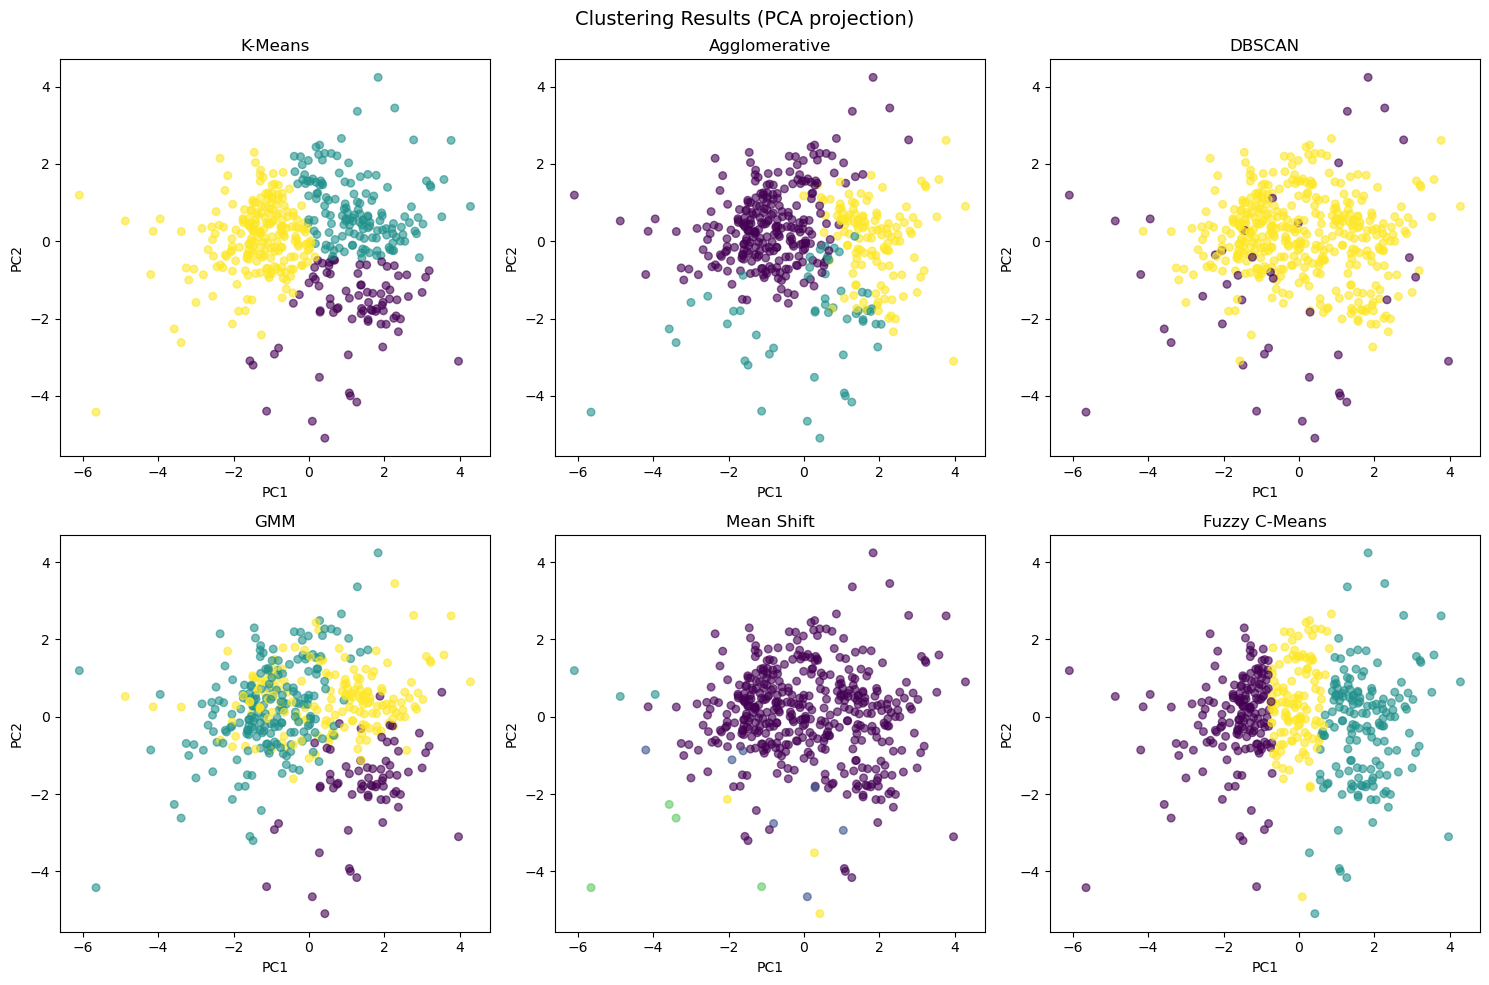

In [37]:
# visual comparison - using PCA for 2D projection
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

all_labels = [
    ('K-Means', kmeans_labels),
    ('Agglomerative', agg_labels),
    ('DBSCAN', dbscan_labels),
    ('GMM', gmm_labels),
    ('Mean Shift', ms_labels),
    ('Fuzzy C-Means', fcm_labels)
]

for idx, (name, labels) in enumerate(all_labels):
    ax = axes.flatten()[idx]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6, s=30)
    ax.set_title(name)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    
plt.suptitle('Clustering Results (PCA projection)', fontsize=14)
plt.tight_layout()
plt.show()

---

## Cluster Interpretation

Going with K-Means (K=3) since it has good metrics and produces interpretable segments.

In [38]:
# add cluster labels to original dataframe
df_clustered = df.copy()
df_clustered['Cluster'] = kmeans_labels

In [39]:
# cluster profiles - spending patterns
cluster_profiles = df_clustered.groupby('Cluster')[spending_cols].agg(['mean', 'median', 'std'])
print("Cluster Spending Profiles:")
cluster_profiles.round(0)

Cluster Spending Profiles:


Fresh                       Milk                   Grocery  \
            mean   median      std     mean  median      std     mean   
Cluster                                                                 
0         2899.0   1492.0   4049.0   7136.0  6300.0   4784.0  12570.0   
1        17043.0  12126.0  16226.0  10560.0  7184.0  10165.0  13334.0   
2        11939.0   9612.0   9741.0   2006.0  1601.0   1502.0   2502.0   

                           Frozen                 Detergents_Paper          \
          median      std    mean  median     std             mean  median   
Cluster                                                                      
0        10502.0  10037.0   607.0   376.0   825.0           5554.0  4218.0   
1         9965.0  11358.0  4133.0  2005.0  6713.0           4987.0  3378.0   
2         2155.0   1629.0  3266.0  2121.0  3795.0            424.0   274.0   

                Delicassen                  
            std       mean  median     std  
Cluster                                     
0        5607.0      783.0   434.0  1093.0  
1        5809.0     2847.0  2005.0  4446.0  
2         529.0      891.0   686.0   766.0

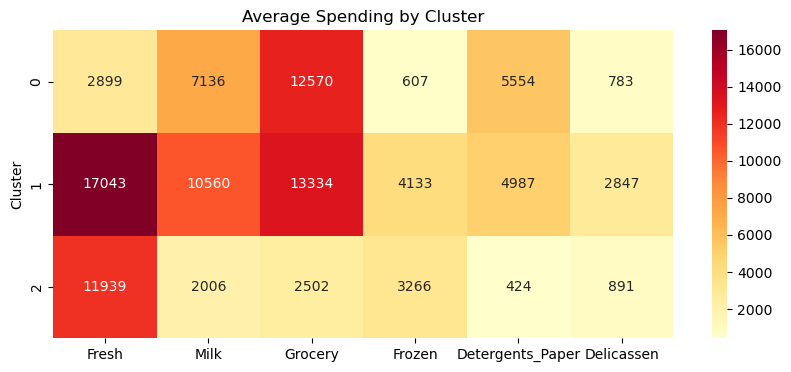

In [40]:
# simpler view - just means
cluster_means = df_clustered.groupby('Cluster')[spending_cols].mean()

# heatmap of cluster means
plt.figure(figsize=(10, 4))
sns.heatmap(cluster_means, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Average Spending by Cluster')
plt.show()

In [41]:
# how do clusters relate to channel and region?
print("Cluster vs Channel:")
print(pd.crosstab(df_clustered['Cluster'], df_clustered['Channel'], normalize='index').round(3))

print("\nCluster vs Region:")
print(pd.crosstab(df_clustered['Cluster'], df_clustered['Region'], normalize='index').round(3))

Cluster vs Channel:
Channel      1      2
Cluster              
0        0.400  0.600
1        0.381  0.619
2        0.986  0.014

Cluster vs Region:
Region       1      2      3
Cluster                     
0        0.175  0.125  0.700
1        0.156  0.075  0.769
2        0.188  0.122  0.690


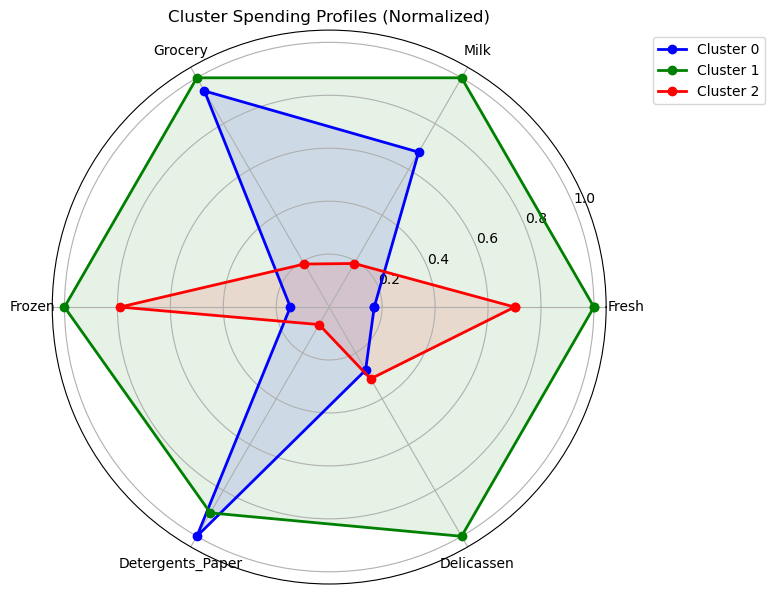

In [42]:
# radar/spider chart for cluster profiles
from math import pi

# normalize means for better visualization
cluster_means_norm = cluster_means.div(cluster_means.max())

# number of categories
categories = spending_cols
N = len(categories)

# angle for each category
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # close the plot

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors = ['blue', 'green', 'red']
for idx, (cluster, row) in enumerate(cluster_means_norm.iterrows()):
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster}', color=colors[idx])
    ax.fill(angles, values, alpha=0.1, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title('Cluster Spending Profiles (Normalized)')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

In [43]:
# lets name the clusters based on their characteristics
print("Cluster Interpretation:")
print("="*60)

for cluster in range(3):
    profile = cluster_means.loc[cluster]
    size = (df_clustered['Cluster'] == cluster).sum()
    
    # determine dominant categories
    top_cats = profile.nlargest(2).index.tolist()
    
    # check channel distribution
    channel_dist = df_clustered[df_clustered['Cluster'] == cluster]['Channel'].value_counts(normalize=True)
    dominant_channel = 'HoReCa' if channel_dist.get(1, 0) > 0.6 else 'Retail' if channel_dist.get(2, 0) > 0.6 else 'Mixed'
    
    print(f"\nCluster {cluster} ({size} customers):")
    print(f"  Top spending: {top_cats[0]}, {top_cats[1]}")
    print(f"  Dominant channel: {dominant_channel}")
    print(f"  Total avg spending: {profile.sum():.0f}")

Cluster Interpretation:

Cluster 0 (80 customers):
  Top spending: Grocery, Milk
  Dominant channel: Mixed
  Total avg spending: 29548

Cluster 1 (147 customers):
  Top spending: Fresh, Grocery
  Dominant channel: Retail
  Total avg spending: 52903

Cluster 2 (213 customers):
  Top spending: Fresh, Frozen
  Dominant channel: HoReCa
  Total avg spending: 21028


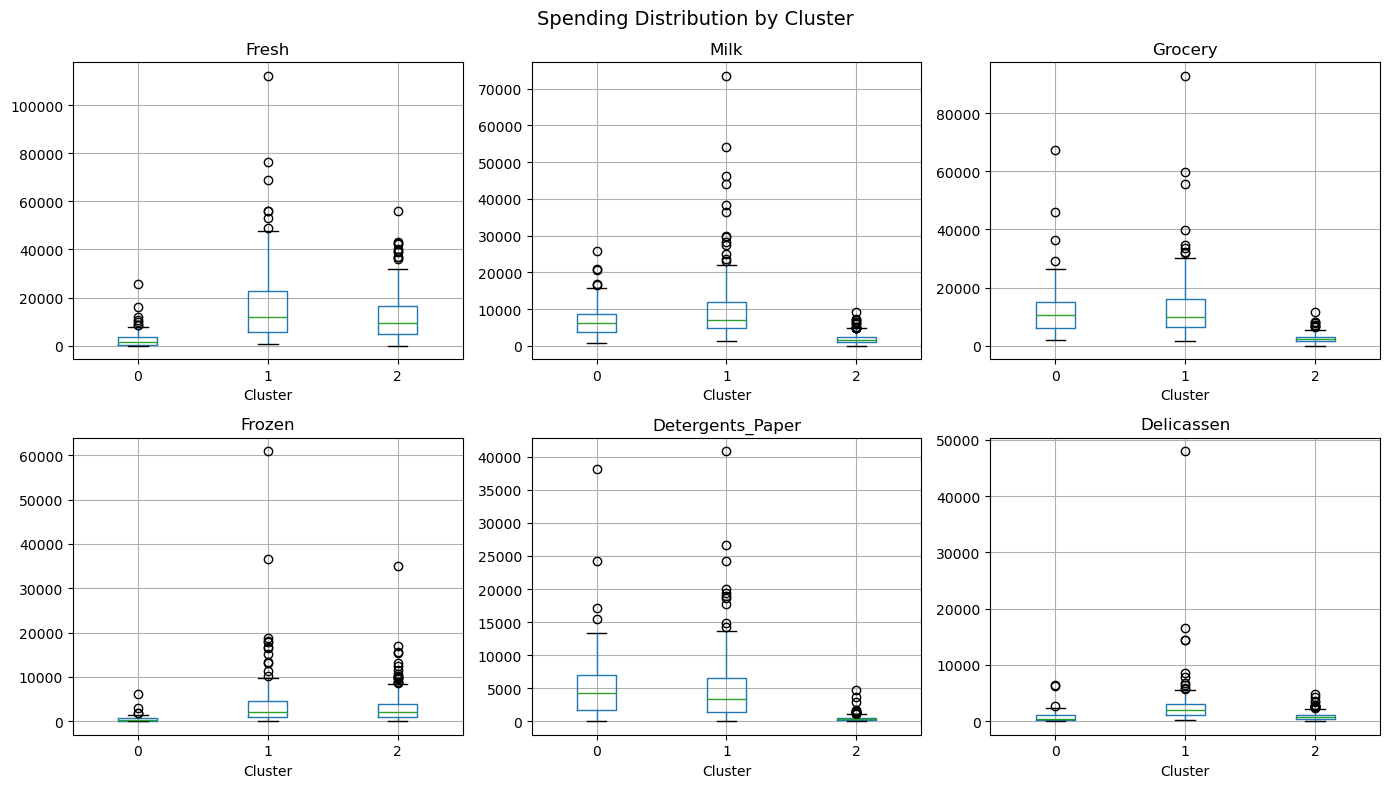

In [44]:
# boxplots of spending by cluster
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(spending_cols):
    df_clustered.boxplot(column=col, by='Cluster', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Cluster')

plt.suptitle('Spending Distribution by Cluster', fontsize=14)
plt.tight_layout()
plt.show()

### Fuzzy C-Means Analysis

One advantage of FCM is we can identify customers who dont fit neatly into one segment.

In [45]:
# add FCM membership to dataframe
df_clustered['FCM_Cluster'] = fcm_labels
df_clustered['FCM_Max_Membership'] = np.max(u, axis=0)

# customers with low max membership - they could belong to multiple segments
uncertain_customers = df_clustered[df_clustered['FCM_Max_Membership'] < 0.5]

print(f"Customers with uncertain segment (max membership < 0.5): {len(uncertain_customers)}")
print(f"These customers show mixed purchasing patterns.")

if len(uncertain_customers) > 0:
    print("\nSample uncertain customers:")
    print(uncertain_customers[spending_cols + ['FCM_Max_Membership']].head(10).round(2))

Customers with uncertain segment (max membership < 0.5): 390
These customers show mixed purchasing patterns.

Sample uncertain customers:
    Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen  \
0   12669  9656     7561     214              2674        1338   
1    7057  9810     9568    1762              3293        1776   
2    6353  8808     7684    2405              3516        7844   
3   13265  1196     4221    6404               507        1788   
4   22615  5410     7198    3915              1777        5185   
5    9413  8259     5126     666              1795        1451   
6   12126  3199     6975     480              3140         545   
8    5963  3648     6192     425              1716         750   
10   3366  5403    12974    4400              5977        1744   
11  13146  1124     4523    1420               549         497   

    FCM_Max_Membership  
0                 0.27  
1                 0.46  
2                 0.33  
3                 0.46  
4         

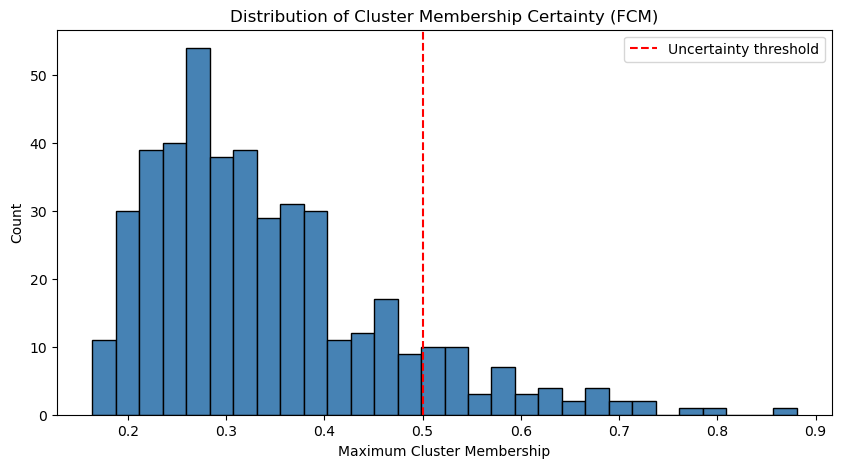

In [46]:
# visualize membership certainty
plt.figure(figsize=(10, 5))
plt.hist(df_clustered['FCM_Max_Membership'], bins=30, color='steelblue', edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', label='Uncertainty threshold')
plt.xlabel('Maximum Cluster Membership')
plt.ylabel('Count')
plt.title('Distribution of Cluster Membership Certainty (FCM)')
plt.legend()
plt.show()

## Summary

### Findings

After testing multiple clustering algorithms on the Wholesale Customers dataset, we found:

1. The optimal number of clusters is 2-3 based on various metrics
2. K-Means and Agglomerative clustering performed best by silhouette score
3. Three distinct customer segments were identified based on spending patterns

### Cluster Descriptions

The three segments show different purchasing behaviors:
- One segment focuses on Fresh products (likely HoReCa channel)
- One segment focuses on Grocery and Detergents/Paper (likely Retail channel)  
- One segment shows more balanced spending across categories

### Algorithm Notes

- K-Means: Simple and effective for this dataset
- Hierarchical: Similar results, useful for visualization
- DBSCAN: Found many noise points, less suitable for this data
- GMM: Good alternative, provides probability estimates
- Mean Shift: Found only 2 clusters
- Fuzzy C-Means: Useful for identifying customers with mixed profiles

### Recommendations

For marketing purposes:
- Segment 1: Focus on fresh product promotions
- Segment 2: Focus on household/grocery bundles
- Segment 3: General promotions, cross-selling opportunities
- Customers with low FCM membership: Consider personalized approaches

In [47]:
print("Final Summary")
print("="*50)
print(f"Dataset: Wholesale Customers ({len(df)} samples)")
print(f"Features: {len(spending_cols)} spending categories")
print(f"Best algorithm: K-Means (silhouette = {silhouette_score(X_scaled, kmeans_labels):.4f})")
print(f"Number of clusters: 3")
print(f"\nCluster sizes:")
for i in range(3):
    n = (kmeans_labels == i).sum()
    print(f"  Cluster {i}: {n} customers ({n/len(df)*100:.1f}%)")

Final Summary
Dataset: Wholesale Customers (440 samples)
Features: 6 spending categories
Best algorithm: K-Means (silhouette = 0.2594)
Number of clusters: 3

Cluster sizes:
  Cluster 0: 80 customers (18.2%)
  Cluster 1: 147 customers (33.4%)
  Cluster 2: 213 customers (48.4%)
